# RNN (Réseaux de neurones récurrents)

Un RNN (Recurrent Neural Network) peut être imaginé comme un réseau neuronal où les couches sont empilées verticalement. Chaque couche représente un moment dans le temps, et les flèches entre les couches symbolisent le passage d'informations d'un pas temporel à un autre. Une flèche entre et sort de chaque couche pour indiquer les entrées et sorties à chaque moment.

Prenons un exemple : si vous souhaitez prédire la direction dans laquelle une balle se déplace. Avec seulement l'instantané affiché à l'écran, vous ne pourrez pas dire grand-chose. Mais en enregistrant plusieurs positions successives de la balle, vous aurez assez d'informations pour prédire son mouvement.

![ball](./asset/ball.gif "segment")

En résumé, les RNN permettent d'ajouter une **mémoire** à une séquence, par exemple pour comprendre comment une balle se déplace.

---

## Applications en texte

C'est pareil avec le texte. Un texte est simplement une séquence de mots.
Les RNN permettent de mieux apprendre les relations entre ces mots.

---

## La mémoire séquentielle

Les RNN excellent dans le traitement des données séquentielles grâce à leur "mémoire séquentielle". Voici une analogie :

Imaginez-vous récitant l’alphabet :
`A B C D E F G H I J K L M N O P Q R S T U V W X Y Z`
C'est facile, car cette séquence est ancrée dans votre mémoire depuis l’enfance.

Maintenant, essayez de réciter l’alphabet **à l’envers** :
`Z Y X W V U T S R Q P O N M L K J I H G F E D C B A`
C'est plus difficile parce que cette séquence est moins familière.

Si vous commencez à partir d’une lettre comme **F**, vous aurez peut-être du mal au début, mais dès que votre cerveau reconnaît le modèle, la suite se fait naturellement. Ce phénomène résulte de la manière dont vous avez appris : la séquence familière est plus facile à réciter.

---

## Les Réseaux de Neurones Récurrents

Les RNN encapsulent le concept de **mémoire séquentielle**. En revanche, les réseaux neuronaux conventionnels (FFNN - Feed-Forward Neural Network) traitent les entrées indépendamment. Les RNN introduisent des boucles permettant de transmettre l’information entre différentes étapes.

### Comparaison visuelle

1. **Réseau feed-forward classique :**
   ![fdd](./asset/Feed_forward_neural_net.gif "segment")

2. **Ajout de boucles pour capturer des informations séquentielles :**
   <img src="./asset/Feed_forward_rnn.gif" alt="image" width="auto" height="500">

3. **Représentation complète des itérations :**
   <img src="./asset/rnn_struct.png" alt="image" width="auto" height="300">

---

## Exemple pratique : Décodage d'une phrase

Prenons la phrase : **"Quelle heure est-il ?"**

**Étape 1 :** Tokenisation (division en séquences).
![01](./asset/rnn01.gif "segment")

**Étape 2 :** Injecter "Quelle" dans le RNN.
![02](./asset/rnn02.gif "segment")

**Étape 3 :** Ajouter "heure" avec l'état caché précédent (hidden state).
![03](./asset/rnn03.gif "segment")

**Étape 4 :** Répéter le processus avec tous les mots. À la dernière étape, le RNN aura appris la structure de toute la phrase.
![04](./asset/rnn04.gif "segment")

**Étape 5 :** Utiliser la sortie finale pour une tâche, comme une classification d’intention.
![05](./asset/rnn05.gif "segment")

---

## Pseudo-code pour un RNN

Voici une représentation pseudo-codée du fonctionnement d'un RNN :

```python
# Python
rnn = RNN()
ff = FeedForwardNN()
hidden_state = [0.0, 0.0, 0.0, 0.0]

for word in sentence:
    output, hidden_state = rnn(word, hidden_state)

prediction = ff(output)
```

Une opération typique dans la couche linéaire :
![rnn_illustrated](./asset/rnn_illustrated.gif "segment")

---

## Le problème du gradient qui disparaît (Vanishing Gradient)

Le problème de "vanishing gradient" désigne une situation où les gradients deviennent si faibles durant la rétropropagation que les poids sont à peine mis à jour, notamment dans les couches précoces. Cela se produit lorsque des gradients inférieurs à 1 sont multipliés à plusieurs reprises, diminuant exponentiellement leur valeur.
Conséquence : difficulté à apprendre des dépendances à long terme dans les données.

![rnn gradiant](./asset/rnn_gradiant.png)

---

## Résumé

### **Avantages :**
1. **Traitement séquentiel :** Idéal pour les séries temporelles, NLP (traitement du langage naturel), et reconnaissance vocale.
2. **Faible coût d'inférence :** Moins gourmand en ressources que Transformateurs car les RNN traitent les séquences pas à pas.

### **Inconvénients :**
1. **Problèmes de gradient (explosion/disparition) :** Rend difficile l’apprentissage des dépendances sur une longue durée.
2. **Dépendances à long terme :** Les RNN classiques peinent à capturer des relations distantes dans les séquences.
3. **Pas de calcul parallèle :** À cause de leur nature séquentielle, les RNN n’exploitent pas pleinement les GPU modernes.

---

# Implémentation Python : Construire un RNN

Nous allons développer et entraîner un RNN simple caractérisé par un apprentissage au **niveau des caractères**.
L'objectif sera de prédire la langue d'un mot basé sur son orthographe. Les données incluront quelques milliers de noms de famille originaires de 18 langues.

In [1]:
import glob
import os
import string
import unicodedata
from io import open

all_letters = string.ascii_letters + " .,;'"

# Nombre total de caractères possibles dans all_letters
n_letters = len(all_letters)


def unicodeToAscii(s):
    """
    Normalise une chaîne Unicode en utilisant la normalisation NFD (sépare les accents des lettres),
    puis filtre les caractères inutiles en conservant uniquement les lettres ASCII définies dans all_letters.
    Référence utile : https://stackoverflow.com/a/518232/2809427
    :param s: Chaîne Unicode à convertir.
    :return: Chaîne convertie en ASCII "pur".
    """
    return ''.join(
            # Normalise et retire les accents ou autres modifications associées
            c for c in unicodedata.normalize('NFD', s)
            # Vérifie que le caractère n'est pas dans la catégorie 'Mn' (non-spacing marks, comme les accents)
            if unicodedata.category(c) != 'Mn'
            # Retient uniquement les caractères présents dans all_letters
            and c in all_letters
            )


def readLines(filename):
    """
    Lit un fichier texte ligne par ligne, enlève les espaces inutiles,
    puis convertit chaque ligne avec `unicodeToAscii` pour garantir des caractères en ASCII.
    :param filename: Nom ou chemin du fichier texte.
    :return: Liste des lignes converties et nettoyées.
    """
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    # Convertit chaque ligne du fichier en ASCII
    return [unicodeToAscii(line) for line in lines]


# Ce dictionnaire contiendra les listes de prénoms catégorisées par langue (exemple : 'French': [prénom1, prénom2, ...])
category_lines = {}

# Cette liste contiendra les noms de toutes les catégories (langues)
all_categories = []

dataset_path = '../dataset/names/names/*.txt'

for filename in glob.glob(dataset_path):
    # Récupère le nom du fichier sans l'extension (ex : 'french' pour 'french.txt')
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print("findFiles", glob.glob(dataset_path))

# Exemple de normalisation : Affiche la conversion Unicode vers ASCII pour un nom particulier
print("unicodeToAscii", unicodeToAscii('Ślusàrski'))

findFiles ['../dataset/names/names/Arabic.txt', '../dataset/names/names/Chinese.txt', '../dataset/names/names/Czech.txt', '../dataset/names/names/Dutch.txt', '../dataset/names/names/English.txt', '../dataset/names/names/French.txt', '../dataset/names/names/German.txt', '../dataset/names/names/Greek.txt', '../dataset/names/names/Irish.txt', '../dataset/names/names/Italian.txt', '../dataset/names/names/Japanese.txt', '../dataset/names/names/Korean.txt', '../dataset/names/names/Polish.txt', '../dataset/names/names/Portuguese.txt', '../dataset/names/names/Russian.txt', '../dataset/names/names/Scottish.txt', '../dataset/names/names/Spanish.txt', '../dataset/names/names/Vietnamese.txt']
unicodeToAscii Slusarski


In [6]:
print(category_lines['Italian'][:5])
print("Number of categories:", n_categories)
print("Number of letters:", n_letters)

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
Number of categories: 18
Number of letters: 57


## Transformer les noms en tokens

Comme nous l'avons vu dans les tutoriels précédents, il est nécessaire de convertir les lettres en tenseurs (vecteurs) à l'aide d'une couche d'embedding.
Ainsi, nous devons transformer chaque lettre en identifiant (ID).

In [7]:
letter_to_id = {l: i for i, l in enumerate(all_letters)}
id_to_letter = {i: l for i, l in enumerate(all_letters)}
print(letter_to_id)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, ' ': 52, '.': 53, ',': 54, ';': 55, "'": 56}


In [8]:
from typing import List


def tokenizer(text: str) -> List[int]:
    """
    split un text en character, et les convertis en ids
    Args:
        text: text a tokneizer

    Returns:

    """
    return [letter_to_id[letter] for letter in text]


tokenizer('Bob')

[27, 14, 1]

## Création du Réseau
Pour simplifier cet exemple, nous utilisons des lots de données au format `[taille du lot, longueur de la séquence]`.
Cependant, nous ne passerons qu'une seule séquence (un seul nom) à travers le modèle.

In [9]:
import torch.nn as nn
import torch


# Cette classe implémente un réseau récurrent de base (RNN) pour traiter des séquences d'entrée.
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size):
        """
        :param vocab_size: Taille du vocabulaire (nombre total de tokens dans la séquence)
        :param hidden_size: Taille de la couche cachée ainsi que celle de l'espace d'embedding
        :param output_size: Nombre de classes dans le jeu de données (par exemple, pour la classification)
        """
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # Initialisation d'une couche d'embedding (embedding layer).
        # Cette couche mappe chaque token d'entrée (représenté par un indice) à un vecteur dense de taille `hidden_size`.
        self.embedding = nn.Embedding(vocab_size, hidden_size)

        # Définition de la couche linéaire `i2h`, qui combine l'entrée courante (embedding)
        # et l'état caché précédent pour calculer le nouvel état caché.
        self.i2h = nn.Linear(hidden_size + hidden_size, hidden_size)

        # Définition de la couche linéaire `h2o`, qui mappe l'état caché courant à un vecteur de taille `output_size`.
        # Ce vecteur représente les scores pour chaque classe possible.
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, hidden=None):
        """
        :param input_ids: Séquence d'IDs correspondant aux tokens [seq_len]
        :param hidden: (optionnel) État caché de la couche précédente (si fourni, sinon il est initialisé à zéro)
        :return: Un tuple composé de la sortie prédite [output_size] et du nouvel état caché [hidden_size]
        """
        # Applique la couche d'embedding à l'entrée :
        # convertit chaque token ID de la séquence en un vecteur dense.
        # La taille résultante est [seq_len, embedding_dim]
        embedding = self.embedding(input_ids)

        # Si aucun état caché préalable n'est fourni, on l'initialise avec des zéros.
        hidden = self.initHidden() if hidden is None else hidden

        # Boucle sur chaque token de la séquence (dimension 0 de l'embedding).
        for i in range(embedding.shape[0]):
            # On concatène l'embedding courant (`embedding[i]`) avec l'état caché précédent
            # pour former un vecteur combiné [emb_dim + hidden_size].
            combined = torch.cat((embedding[i], hidden), 0)

            # Calcul du nouvel état caché en passant le vecteur combiné dans la couche linéaire `i2h`.
            hidden = self.i2h(combined)

            # Applique la fonction d'activation tanh à l'état caché pour limiter les valeurs dans
            # l'intervalle [-1, 1]. Cela aide à éviter les problèmes liés aux gradients explosifs (exploding gradients).
            hidden = torch.tanh(hidden)

            # Calcul de la sortie en passant l'état caché actuel dans la couche linéaire `h2o`.
            # La sortie est un vecteur de taille `output_size`.
            output = self.h2o(hidden)

        # On ajoute une dimension supplémentaire à la sortie afin de l'utiliser avec une fonction de perte
        # qui peut attendre une structure tensorielle spécifique.
        return output.unsqueeze(0), hidden

    def initHidden(self):
        # Initialisation de l'état caché avec des zéros (ne nécessite pas de gradients).
        # Cette méthode est appelée au début d'une nouvelle séquence si aucun état caché n'est fourni.
        return torch.zeros(self.hidden_size, requires_grad=False)

## Test de notre RNN

In [11]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# 1 - On tokenize notre text
tokens = torch.tensor(tokenizer('Bob'))
print("tokens", tokens)

# 2 - On crée notre premier hidden state
hidden = torch.zeros(n_hidden)

# 3 - On passe dans notre RNN
output, next_hidden = rnn(tokens, hidden)
print("next_hidden", next_hidden.shape)
print("output", output.shape)

tokens tensor([27, 14,  1])
next_hidden torch.Size([128])
output torch.Size([1, 18])


**Note** avec la variable `next_hidden` nous pouvons l'utilisez afin d'empiller un autre RNN par dessus

![stack rnn](./asset/stack_rnn.png)

In [12]:
def categoryFromOutput(output: torch.tensor):
    """
    Obtention de notre categorie a partir de l'output
    Args:
        output: output de notre RNN

    Returns:

    """
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


# Get the category from the output
print(categoryFromOutput(output))

('Greek', 7)


We will also want a quick way to get a training example (a name and its language):

## Train model

Each loop of training will:
- Create input tokens
- Create a zeroed initial hidden state
- Read each letter in and
    - Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [15]:
import random  # Importation du module random pour la génération de nombres aléatoires


def randomChoice(l):
    """
    Choisit un élément aléatoire dans une liste donnée.
    :param l: Liste d'éléments parmi lesquels effectuer une sélection.
    :return: Un élément choisi au hasard dans la liste.
    """
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    """
    Génère un exemple d'entraînement aléatoire pour un modèle.
    :return: Un tuple contenant :
        - la catégorie sélectionnée aléatoirement,
        - une ligne associée à cette catégorie (elle aussi choisie aléatoirement),
        - la représentation tensorielle de la catégorie (category_tensor),
        - la représentation tensorielle des ID des tokens générés à partir de la ligne (input_ids).
    :rtype: tuple
    """
    # Sélection aléatoire d'une catégorie depuis la liste globale `all_categories`
    category = randomChoice(all_categories)

    # Sélection aléatoire d'une ligne associée à cette catégorie (provenant de `category_lines`)
    line = randomChoice(category_lines[category])

    # Conversion de la catégorie en un tenseur PyTorch :
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    # Tokenisation de la ligne :
    # La fonction `tokenizer` transforme la ligne en une liste d'identifiants numériques,
    # qui est ensuite convertie en un tenseur PyTorch.
    # Cela permet de préparer les données pour l'entrée dans un réseau de neurones.
    return category, line, category_tensor, torch.tensor(tokenizer(line))


# Boucle pour générer 10 exemples d'entraînement aléatoires et les afficher
for i in range(10):
    # Appel de la fonction `randomTrainingExample` pour obtenir un exemple
    category, line, category_tensor, input_ids = randomTrainingExample()

    # Affiche la catégorie, la ligne et les identifiants des tokens générés
    print('category =', category, '/ line =', line, '/ input_ids =', input_ids)

category = Russian / line = Makhalov / input_ids = tensor([38,  0, 10,  7,  0, 11, 14, 21])
category = Italian / line = Parisi / input_ids = tensor([41,  0, 17,  8, 18,  8])
category = Korean / line = Nam / input_ids = tensor([39,  0, 12])
category = Dutch / line = Kolijn / input_ids = tensor([36, 14, 11,  8,  9, 13])
category = Spanish / line = Gonzales / input_ids = tensor([32, 14, 13, 25,  0, 11,  4, 18])
category = Dutch / line = Klerken / input_ids = tensor([36, 11,  4, 17, 10,  4, 13])
category = German / line = Kunkel / input_ids = tensor([36, 20, 13, 10,  4, 11])
category = Spanish / line = Alvarez / input_ids = tensor([26, 11, 21,  0, 17,  4, 25])
category = Russian / line = Vylko / input_ids = tensor([47, 24, 11, 10, 14])
category = English / line = Kidd / input_ids = tensor([36,  8,  3,  3])


In [16]:
import time
import math

# Déclaration du nombre d'itérations pour l'entraînement.
n_iters = 50000

print_every = 5000

current_loss = 0.0
all_losses = []

learning_rate = 0.01

# Définition de la fonction de perte (loss function) : CrossEntropyLoss est adaptée pour un problème
# de classification où les sorties du modèle représentent des probabilités par catégorie (distribution softmax).
criterion = nn.CrossEntropyLoss()

# Taille de l'état caché (hidden size) pour le RNN, soit la dimension de la mémoire persistante.
n_hidden = 128

# Initialisation du modèle RNN, avec des dimensions pour l'entrée (n_letters),
# l'état caché (n_hidden) et les sorties (n_categories).
rnn = RNN(n_letters, n_hidden, n_categories)

# Définition de l'optimiseur : l'algorithme Stochastic Gradient Descent est utilisé ici
# avec un facteur de moment (momentum) pour stabiliser les mises à jour.
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

rnn = rnn.to(device)
rnn.train()


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


start = time.time()
for iter in range(1, n_iters + 1):

    # Création d'un exemple d'apprentissage aléatoire en récupérant une catégorie,
    # une ligne de texte, son tenseur de catégorie et les identifiants des tokens d'entrée.
    category, line, category_tensor, input_ids = randomTrainingExample()

    # Transfert des tenseurs d'entrée et de catégorie vers le dispositif
    # (CPU ou GPU, selon ce qui a été défini auparavant).
    input_ids = input_ids.to(device)
    category_tensor = category_tensor.to(device)

    # Initialisation de l'état caché du RNN (pour le début d'une nouvelle séquence)
    hidden = rnn.initHidden().to(device)

    # Réinitialisation des gradients avant chaque passage en forward et backward.
    # Ceci est une étape essentielle car PyTorch accumule les gradients au lieu de
    # les écraser à chaque appel à `backward()`.
    rnn.zero_grad()

    # Calcul de l'output du modèle RNN en passant les identifiants d'entrée (input_ids)
    # et l'état caché initialisé.
    output, hidden = rnn(input_ids, hidden)

    # Calcul de la perte (loss) entre les sorties prédites par le modèle `output`
    # et la vérité terrain (category_tensor). La fonction criterion (CrossEntropyLoss)
    # calcule cette différence.
    loss = criterion(output, category_tensor)

    # Calcul des gradients par backpropagation : cette étape met à jour les gradients
    # des poids du modèle en fonction de la perte calculée.
    loss.backward()

    # Application de la technique de clipping des gradients pour éviter le problème
    # des gradients explosifs. En s'assurant que les gradients sont limités à une norme maximale
    # (max_norm=1.0 ici), l'entraînement devient plus stable, surtout pour les RNN. qui cummuble a plusieur reprise les hiddens state
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=1.0)

    # Mise à jour des poids du modèle en utilisant l'optimiseur défini préalablement (SGD).
    # Les poids sont ajustés selon les gradients calculés lors de `loss.backward()` et le taux d'apprentissage.
    optimizer.step()

    # Accumulation de la perte courante pour calcul d'une moyenne sur une période donnée (print_every).
    current_loss += loss.item()

    # Affichage des métriques d'entraînement périodiquement (tous les `print_every` itérations).
    if iter % print_every == 0:
        # Ajout de la perte moyenne des dernières périodes à la liste `all_losses`
        # pour analyse ou visualisation ultérieure.
        all_losses.append(current_loss / print_every)

        # Affichage du numéro d’itération et de la perte moyenne.
        print(f'  iter {iter} loss: {current_loss / print_every:.3f}')

        # Réinitialisation de la perte cumulée après chaque affichage.
        current_loss = 0.0

cuda
  iter 5000 loss: 2.027
  iter 10000 loss: 1.646
  iter 15000 loss: 1.513
  iter 20000 loss: 1.358
  iter 25000 loss: 1.257
  iter 30000 loss: 1.199
  iter 35000 loss: 1.040
  iter 40000 loss: 1.023
  iter 45000 loss: 0.917
  iter 50000 loss: 0.870
  iter 55000 loss: 0.780
  iter 60000 loss: 0.753
  iter 65000 loss: 0.791
  iter 70000 loss: 0.727
  iter 75000 loss: 0.764
  iter 80000 loss: 0.751
  iter 85000 loss: 0.683
  iter 90000 loss: 0.658
  iter 95000 loss: 0.630
  iter 100000 loss: 0.649
  iter 105000 loss: 0.634


Plot results

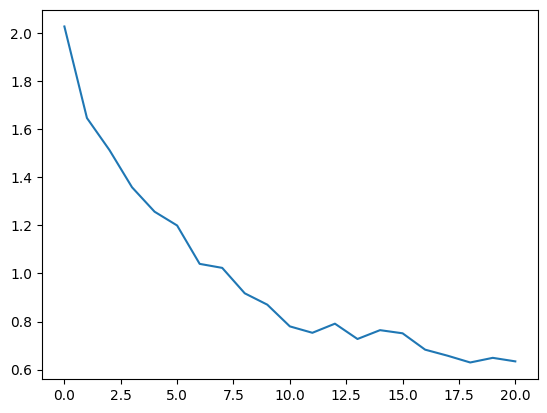

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_9/119051227.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories,
/tmp/ipykernel_9/119051227.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)  # Ajout des noms des catégories sur l'axe des ordonnées


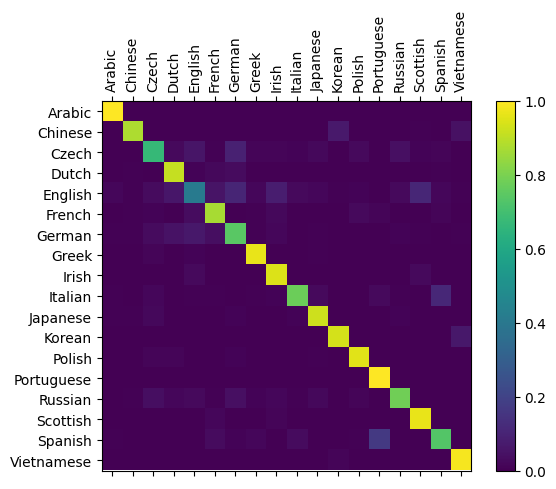

In [19]:
import matplotlib.ticker as ticker

# Création d'une matrice de confusion pour suivre les prédictions correctes et incorrectes
# Initialise une matrice contenant uniquement des zéros (taille : n_categories x n_categories)
confusion = torch.zeros(n_categories,
                        n_categories)
n_confusion = 10000  # Nombre d'exemples à traiter pour la création de la matrice de confusion
softmax = nn.LogSoftmax(dim=1)  # Softmax appliqué sur la dernière dimension (probabilité log des classes)
rnn.eval()  # Met le RNN en mode évaluation (désactivation du dropout et fonctions spécifiques à l'entraînement)

# Parcourir plusieurs exemples pour enregistrer les classifications correctes et incorrectes
for i in range(n_confusion):
    # Obtenir un exemple d'entraînement aléatoire
    category, line, category_tensor, input_ids = randomTrainingExample()

    # Initialisation de l'état caché avec des zéros pour le début d'une nouvelle séquence.
    hidden = rnn.initHidden().to(device)
    input_ids = input_ids.to(device)

    # Passage de la séquence dans le réseau RNN
    output, hidden = rnn(input_ids, hidden)

    # Extraction de la catégorie prédite à partir de la sortie du modèle
    # La fonction categoryFromOutput utilise le résultat du softmax pour déterminer la classe prédite
    guess, guess_i = categoryFromOutput(softmax(output))  # guess_i : index de la catégorie prédite
    category_i = all_categories.index(category)  # Index réel de la catégorie associée à l'exemple

    # Mise à jour de la matrice de confusion :
    # Les prédictions sont enregistrées en incrémentant la case correspondant à la catégorie réelle (ligne) et prédite (colonne)
    confusion[category_i][guess_i] += 1

# Normalisation de la matrice de confusion :
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Configuration du graphique pour visualiser la matrice de confusion
fig = plt.figure()  # Création d'une figure
ax = fig.add_subplot(111)  # Ajout d'un subplot (graphe principal)
cax = ax.matshow(confusion.numpy())  # Affichage des valeurs de la matrice de confusion sous forme de heatmap
fig.colorbar(cax)  # Ajout d'une barre de couleurs pour indiquer l'échelle

# Configuration des axes du graphique
ax.set_xticklabels([''] + all_categories,
                   rotation=90)  # Ajout des noms des catégories sur l'axe des abscisses ; rotation verticale pour lisibilité
ax.set_yticklabels([''] + all_categories)  # Ajout des noms des catégories sur l'axe des ordonnées

# Forcer l'affichage d'un tick à chaque élément (une catégorie par ligne/colonne)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Espacement régulier de 1 tick par catégorie
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Affichage du graphique
plt.show()

# LSTM en 5 minutes
[ressources](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

## Introduction
Les Long Short-Term Memory (LSTM) sont une architecture spécifique des réseaux neuronaux récurrents (RNN) conçue pour mémoriser de longues séquences de données. Cela les rend très performants pour des tâches comme la prédiction de séries temporelles, le traitement du langage naturel, et d'autres applications séquentielles.

Un réseau neuronal récurrent (RNN) fonctionne en conservant une forme de mémoire en traitant des séquences. Cela se fait via une boucle au sein du réseau qui permet de transférer des informations d'une étape de la séquence à l'autre.

Les LSTMs améliorent la structure de base des RNN grâce à une unité récurrente plus complexe qui contrôle plus efficacement le flux d'information. Ils résolvent ainsi le problème de **dépendances à long terme**, une limitation des RNN classiques. C'est pourquoi ils sont souvent utilisés en deep learning pour résoudre des problèmes séquentiels complexes.

![lstm](./asset/lstm.png)

---

## Forget gate (Porte d’oubli)
**Décide quelles informations garder ou oublier**

La porte d’oubli détermine quelles informations doivent être conservées ou effacées. Les informations sont issues de l’état caché précédent et de l'entrée à l'instant actuel. Ces données passent par une fonction sigmoïde qui transforme les valeurs entre `0` (oublier) et `1` (garder).

![forget](./asset/lstm_forget.gif "segment")

---

## Input gate (Porte d’entrée)
**Ajoute les informations pertinentes issues de l’étape actuelle**

Pour mettre à jour l’état interne (cell state), on utilise la porte d’entrée. Deux opérations ont lieu :
1. Les valeurs de l'état caché précédent et de l’entrée actuelle passent dans une fonction sigmoïde pour déterminer les informations importantes (sortant entre `0` et `1`).
2. Simultanément, ces mêmes valeurs passent dans une fonction `tanh`, qui les limite entre `-1` et `1`.

Ces deux sorties (sigmoïde et tanh) sont multipliées. La sortie de `sigmoïde` décide des informations importantes venant de la sortie de `tanh`.

![input](./asset/lstm_input.gif "segment")

---

## Cell State (État de la cellule)
**Combine les informations de l’entrée et de l’oubli**

L’état interne est mis à jour en deux étapes :
1. L’état interne précédent est multiplié élément par élément avec le vecteur de la porte d’oubli. Cela permet de supprimer des valeurs jugées non pertinentes.
2. Ensuite, les nouvelles informations issues de la porte d’entrée (multiplication de sigmoïde et tanh) sont ajoutées élément par élément, créant un nouvel état interne.

![cell](./asset/lstm_cell.gif "segment")

---

## Output gate (Porte de sortie)
**Détermine le nouvel état caché**

La porte de sortie décide du nouvel état caché basé sur deux éléments :
1. Les valeurs de l’état caché précédent et de l’entrée actuelle passent par une fonction sigmoïde.
2. L’état interne modifié passe par une fonction `tanh`.

Les sorties de ces deux fonctions sont multipliées élément par élément pour générer le nouvel état caché. Ce dernier contient des informations résumées des étapes précédentes et est utilisé pour faire des prédictions. Le nouvel état caché ainsi que le nouvel état interne sont ensuite transférés à l’étape suivante.

![ouput](./asset/lstm_output.gif "segment")

---

## Code
**Exemple de pseudocode pour illustrer un LSTM :**
![lstm_code](./asset/lstm_pseudo_code.png)

### Étapes principales dans un LSTM :
1. L’état caché précédent et l’entrée actuelle sont **concaténés**. On appelle ce résultat `combine`.
2. `Combine` est passé dans une **porte d’oubli**, supprimant les données peu pertinentes.
3. Une **couche candidate** est créée à partir de `combine`, contenant les valeurs possibles à ajouter à l’état interne.
4. `Combine` passe également dans une **porte d’entrée**, qui détermine quelles données de la couche candidate doivent être ajoutées à l’état interne.
5. L’état interne est mise à jour en combinant les sorties des portes d’entrée, d’oubli et l’état interne précédent.
6. La sortie est finalement calculée.
7. La sortie multipliée par l’état interne nouvellement calculé donne le nouveau **état caché**.